# Library

In [1]:
import torch
import torchvision.transforms as T
from torchvision.utils import make_grid
from PIL import Image
from model.glow import Glow64x64V0, Glow256x256V0

In [2]:
tt = T.ToTensor()
ttp = T.ToPILImage()

# Model

In [3]:
def load_glow_64x64_imagenet():
    ckpt_path = '/home/dajinhan/nas_dajinhan/experiments/glow/result/glow_64x64_imagenet.ckpt'
    pretrained = {'ckpt_path': ckpt_path}
    net = Glow64x64V0(pretrained).eval()
    return net

def load_glow_64x64_celeba():
    ckpt_path = '/home/dajinhan/nas_dajinhan/experiments/glow/result/glow_64x64_celeba.ckpt'
    pretrained = {'ckpt_path': ckpt_path}
    net = Glow64x64V0(pretrained).eval()
    return net

def load_glow_256x256_celeba():
    ckpt_path = '/home/dajinhan/nas_dajinhan/experiments/glow/result/glow_256x256_celeba.ckpt'
    pretrained = {'ckpt_path': ckpt_path}
    net = Glow256x256V0(pretrained).eval()
    return net

# Sample

In [4]:
norm_mean = [0.5, 0.5, 0.5]
norm_std = [1.0, 1.0, 1.0]

preprocess = T.Normalize(
    mean=norm_mean, 
    std=norm_std)
reverse_preprocess = T.Normalize(
    mean=[-m/s for m,s in zip(norm_mean, norm_std)],
    std=[1/s for s in norm_std])

In [5]:
def sample_64(net, n_samples=1, temp=0.7):
    z_final = temp * torch.randn((n_samples,96,4,4)) * net.final_temp
    z_splits = [
        temp * torch.randn((n_samples,6,32,32)) * net.inter_temp,
        temp * torch.randn((n_samples,12,16,16)) * net.inter_temp,
        temp * torch.randn((n_samples,24,8,8)) * net.inter_temp,
        None,
    ]
    conditions = [None] * len(net.blocks)
    x_sample = net.reverse(z_final, conditions, z_splits)
    x_sample = reverse_preprocess(x_sample)
    x_sample = torch.clamp(x_sample, 0,1)
    return x_sample

def sample_256(net, n_samples=1, temp=0.7):
    z_final = temp * torch.randn((n_samples,384,4,4)) * net.final_temp
    z_splits = [
        temp * torch.randn((n_samples,6,128,128)) * net.inter_temp,
        temp * torch.randn((n_samples,12,64,64)) * net.inter_temp,
        temp * torch.randn((n_samples,24,32,32)) * net.inter_temp,
        temp * torch.randn((n_samples,48,16,16)) * net.inter_temp,
        temp * torch.randn((n_samples,96,8,8)) * net.inter_temp,
        None,
    ]
    conditions = [None] * len(net.blocks)
    x_sample = net.reverse(z_final, conditions, z_splits)
    x_sample = reverse_preprocess(x_sample)
    x_sample = torch.clamp(x_sample, 0,1)
    return x_sample

def sample_grid(x, n_row):
    imgs = [img.cpu() for img in x]
    grid = make_grid(imgs, n_row)
    return ttp(grid)

In [6]:
def x_to_z(net, x):
    x = preprocess(x)
    conditions = [None] * len(net.blocks)
    z_final, _, _, z_splits = net.forward(x, conditions)
    return z_final, z_splits

def z_to_x(net, z_final, z_splits):
    conditions = [None] * len(net.blocks)
    x = net.reverse(z_final, conditions, z_splits)
    x = reverse_preprocess(x)
    return x

def sample_temperature(net, z_final, z_splits):
    temperatures = [0, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    def adjust_temperature(z):
        return torch.cat([torch.stack([z_i * temp for temp in temperatures], dim=0) for z_i in z], dim=0)
    z_final = adjust_temperature(z_final)
    z_splits = [adjust_temperature(z_split) if z_split is not None else None for z_split in z_splits]
    
    conditions = [None] * len(net.blocks)
    x_sample = net.reverse(z_final, conditions, z_splits)
    x_sample = reverse_preprocess(x_sample)
    x_sample = torch.clamp(x_sample, 0,1)
    return x_sample

def sample_interpolate(net, z1_, z2_):
    temperatures = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    z1_final, z1_splits = z1_
    z2_final, z2_splits = z2_
    def adjust_interpolate(z1, z2):
        return torch.cat([ torch.stack([z1_i*temp + z2_i*(1-temp) for temp in temperatures], dim=0) for z1_i, z2_i in zip(z1,z2)], dim=0)
    z_final = adjust_interpolate(z1_final, z2_final)
    z_splits = [adjust_interpolate(z1_split, z2_split) if z1_split is not None else None for z1_split, z2_split in zip(z1_splits, z2_splits)]

    conditions = [None] * len(net.blocks)
    x_sample = net.reverse(z_final, conditions, z_splits)
    x_sample = reverse_preprocess(x_sample)
    x_sample = torch.clamp(x_sample, 0,1)
    return x_sample

    

## Glow_64x64_imagenet

In [7]:
net = load_glow_64x64_imagenet()

/home/dajinhan/nas_dajinhan/workspace/glow-pytorch/demo/model/common/flow_module/flow.py:119: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  w_s = torch.from_numpy(w_s)


Load flownet - Checkpoint :  /home/dajinhan/nas_dajinhan/experiments/glow/result/glow_64x64_imagenet.ckpt


In [8]:
x = sample_64(net, n_samples=64, temp=1.0)

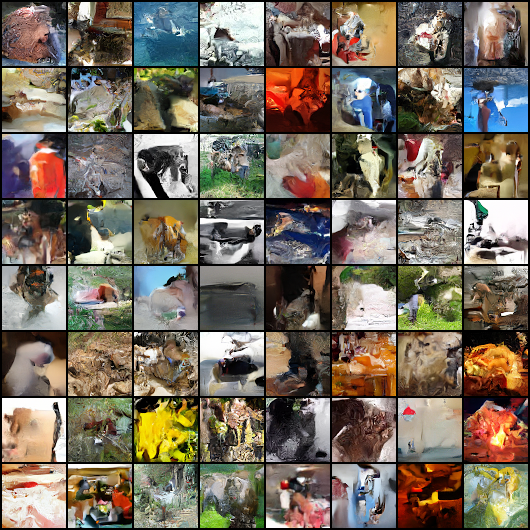

In [9]:
sample_grid(x, 8)
# ttp(x[0])

## Glow_64x64_celeba

In [10]:
net = load_glow_64x64_celeba()

Load flownet - Checkpoint :  /home/dajinhan/nas_dajinhan/experiments/glow/result/glow_64x64_celeba.ckpt


In [11]:
x = sample_64(net, n_samples=64, temp=1.0)

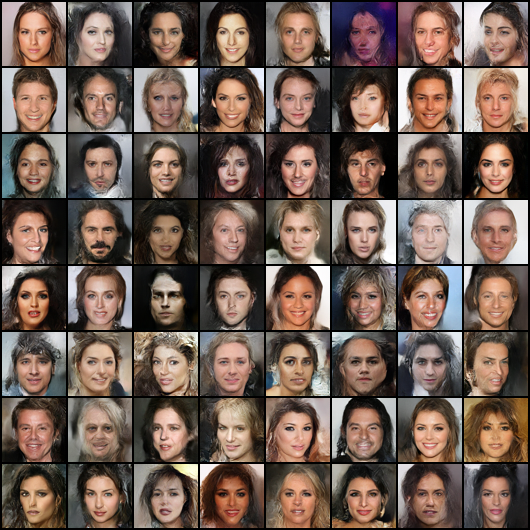

In [12]:
sample_grid(x, 8)
# ttp(x[0])

### Temperature

In [13]:
x_samples = torch.stack([x[3], x[4]], dim=0)
z_final, z_splits = x_to_z(net, x_samples)


In [14]:
x_temperature = sample_temperature(net, z_final, z_splits)

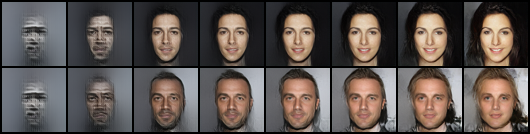

In [15]:
sample_grid(x_temperature, 8)


### Interpolation

In [16]:
x1 = torch.stack([x[44], x[13]], dim=0)
x2 = torch.stack([x[62], x[16]], dim=0)

z1_final, z1_splits = x_to_z(net, x1)
z2_final, z2_splits = x_to_z(net, x2)

In [17]:
x_interpolation = sample_interpolate(net, (z1_final, z1_splits), (z2_final, z2_splits))

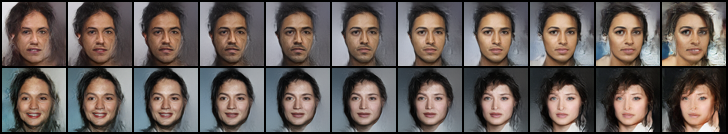

In [18]:
sample_grid(x_interpolation, 11)

## Glow_256x256_celeba

In [19]:
net = load_glow_256x256_celeba()

Load flownet - Checkpoint :  /home/dajinhan/nas_dajinhan/experiments/glow/result/glow_256x256_celeba.ckpt


In [20]:
x = sample_256(net, n_samples=4, temp=0.7)

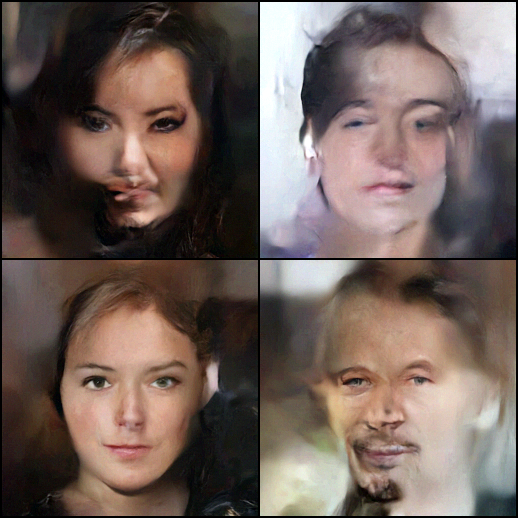

In [21]:
sample_grid(x, 2)
# ttp(x[0])